Cell 1 — Install packages

In [1]:
# Install required packages (run once)
%pip install -q mne PyWavelets scikit-learn seaborn imbalanced-learn
%pip install -q azureml-core azure-ai-ml azure-identity

print("✅ Packages installed (if no errors above).")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed (if no errors above).


Cell 2 — Load libraries + set seeds

In [2]:
# Basic utilities
import os
import random
import pickle

# Arrays
import numpy as np

# EEG processing
import mne
import pywt

# ML tools
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix, roc_auc_score

# Balancing
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Helpers
from typing import Optional, Union, Sequence, Dict, Tuple, List

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

try:
    tf.keras.utils.enable_interactive_logging()
except Exception:
    pass

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports done + seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


✅ Imports done + seeds set.


Cell 3 — Azure download + load AD arrays + build labels (EXCLUDING last 5)

In [3]:
import os
import numpy as np

# --------------------------------------------------
# Local EEG data paths
# --------------------------------------------------
NEG_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_positive.npy"

print("[STEP 1] Loading local .npy files...")

# --------------------------------------------------
# Load arrays
# --------------------------------------------------
if not os.path.exists(NEG_PATH):
    raise FileNotFoundError(f"❌ File not found: {NEG_PATH}")

if not os.path.exists(POS_PATH):
    raise FileNotFoundError(f"❌ File not found: {POS_PATH}")

X_neg_full = np.load(NEG_PATH, allow_pickle=False).astype(np.float32)
X_pos_full = np.load(POS_PATH, allow_pickle=False).astype(np.float32)

print("✅ Arrays loaded:")
print("  ad_negative.npy (full):", X_neg_full.shape)
print("  ad_positive.npy (full):", X_pos_full.shape)

# --------------------------------------------------
# Exclude samples (AS REQUESTED)
# --------------------------------------------------
if X_neg_full.shape[0] <= 5 or X_pos_full.shape[0] <= 31:
    raise ValueError("❌ Not enough samples to exclude requested trials safely.")

X_neg = X_neg_full[:-5]
X_pos = X_pos_full[:-31]

print("✅ After removing last 5 / 31 trials:")
print("  ad_negative.npy:", X_neg.shape)
print("  ad_positive.npy:", X_pos.shape)

# --------------------------------------------------
# Labels
# --------------------------------------------------
y_neg = np.zeros((X_neg.shape[0],), dtype=np.int32)
y_pos = np.ones((X_pos.shape[0],), dtype=np.int32)

# --------------------------------------------------
# Combine dataset
# --------------------------------------------------
X_all_trials = np.concatenate([X_neg, X_pos], axis=0)
y_all_trials = np.concatenate([y_neg, y_pos], axis=0)

print("[STEP 1] Combined dataset:")
print("  X_all_trials:", X_all_trials.shape)
print("  y_all_trials:", y_all_trials.shape)
print("  Class counts:", np.unique(y_all_trials, return_counts=True))


[STEP 1] Loading local .npy files...
✅ Arrays loaded:
  ad_negative.npy (full): (31, 127, 150000)
  ad_positive.npy (full): (46, 127, 150000)
✅ After removing last 5 / 31 trials:
  ad_negative.npy: (26, 127, 150000)
  ad_positive.npy: (15, 127, 150000)
[STEP 1] Combined dataset:
  X_all_trials: (41, 127, 150000)
  y_all_trials: (41,)
  Class counts: (array([0, 1], dtype=int32), array([26, 15]))


* downsample to 500 Hz

In [4]:
import numpy as np
import mne

sfreq_in = 1000
sfreq_out = 500

# Cast to float64 for MNE, then back to float32 if you want
X_all_trials_ds = mne.filter.resample(
    X_all_trials.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("Before:", X_all_trials.shape, X_all_trials.dtype)
print("After: ", X_all_trials_ds.shape, X_all_trials_ds.dtype)


Before: (41, 127, 150000) float32
After:  (41, 127, 75000) float32


Cell 4 — Helper + leakage-safe preprocessing classes

In [5]:
def _names_from_index_mapping(n_channels, index_to_name):
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

def _make_raw(eeg, sfreq, ch_names, use_standard_1020=True):
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)

    montage_applied = False
    if use_standard_1020:
        try:
            mont = mne.channels.make_standard_montage("standard_1020")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
            montage_applied = True
        except Exception:
            montage_applied = False

    return raw, montage_applied

class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.random_state = random_state
        self.ica_ = None
        self._n_ch = None

    def fit(self, X):
        C = X.shape[0]
        self._n_ch = C
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        k = int(min(self.n_components, C))
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)
        S = self.ica_.fit_transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)
        return self

    def transform(self, X):
        assert self.ica_ is not None, "WaveletICA not fitted yet."
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica_.transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        elif Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

class EEGPreprocessor:
    def __init__(
        self,
        *,
        index_to_name=None,
        use_standard_1020=True,
        resample_to=None,
        notch_freqs=50.0,
        highpass=0.05,
        bad_point_z=6.0,
        bad_channel_z=5.0,
        interpolate_bad_channels=False,
        car=True,
        use_wica=True,
        wica_components=10,
        wica_wavelet="db4",
        wica_level=3,
        wica_random_state=42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.resample_to = resample_to
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.bad_channel_z = bad_channel_z
        self.interpolate_bad_channels = interpolate_bad_channels
        self.car = car
        self.use_wica = use_wica

        self._sfreq_out = None
        self._train_mu = None
        self._train_sd = None

        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    @property
    def sfreq_out(self):
        assert self._sfreq_out is not None, "Preprocessor not run yet."
        return float(self._sfreq_out)

    def _filter_and_reference(self, raw):
        if self.resample_to is not None and float(self.resample_to) != float(raw.info["sfreq"]):
            raw.resample(self.resample_to, npad="auto")
        self._sfreq_out = float(raw.info["sfreq"])

        if self.notch_freqs is not None:
            raw.notch_filter(freqs=self.notch_freqs, verbose=False)

        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)

        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw):
        X = raw.get_data()
        mu = self._train_mu
        sd = self._train_sd
        assert mu is not None and sd is not None, "Training stats not set."

        hi = mu + self.bad_point_z * sd
        lo = mu - self.bad_point_z * sd
        mask = (X > hi) | (X < lo)

        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def fit(self, X_train, sfreq):
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw_train, _ = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw_train)

        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12

        if self.use_wica:
            self._wica.fit(Xt)

        return self

    def transform(self, X, sfreq):
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw, _ = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw)
        self._repair_transients_with_train_stats(raw)

        Xf = raw.get_data()
        if self.use_wica:
            Xf = self._wica.transform(Xf)

        return Xf.astype(np.float32, copy=False), self.sfreq_out

    def fit_transform(self, X_train, sfreq):
        self.fit(X_train, sfreq)
        X_clean, fs_out = self.transform(X_train, sfreq)
        return X_clean, fs_out

print("✅ Preprocessing classes loaded.")


✅ Preprocessing classes loaded.


Cell 5 — Set sampling frequency + Preprocess all trials

In [6]:
print("[STEP 2] Starting preprocessing...")

fs = 500.0  # <-- CHANGE if needed
print(f"[STEP 2] Using fs={fs} Hz")

CHANNEL_MAP = None

pre = EEGPreprocessor(
    index_to_name=CHANNEL_MAP,
    use_standard_1020=True,
    resample_to=None,
    notch_freqs=[50.0, 100.0, 150.0],
    highpass=0.05,
    bad_point_z=6.0,
    bad_channel_z=5.0,
    interpolate_bad_channels=False,
    car=True,
    use_wica=True,
    wica_components=10,
    wica_wavelet="db4",
    wica_level=3,
    wica_random_state=42
)

max_calib_trials = min(10, X_all_trials.shape[0])
print(f"[STEP 2] Fitting preprocessor on first {max_calib_trials} trials...")

calib_trials = X_all_trials[:max_calib_trials]
X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)

X_calib_clean, fs_out = pre.fit_transform(X_calib, fs)
print(f"[STEP 2] Preprocessor fitted ✅ | fs_out={fs_out} Hz")

data_clean = []
for i in range(X_all_trials.shape[0]):
    X_clean, _ = pre.transform(X_all_trials[i], fs)
    data_clean.append(X_clean.astype(np.float32, copy=False))
    if (i + 1) % 5 == 0 or (i + 1) == X_all_trials.shape[0]:
        print(f"[STEP 2] Preprocessed {i+1}/{X_all_trials.shape[0]} trials...")

data_clean = np.array(data_clean, dtype=np.float32)

print("[STEP 2] Done preprocessing ✅")
print("  data_clean shape:", data_clean.shape)
print("  labels shape    :", y_all_trials.shape)
print("  class counts    :", np.unique(y_all_trials, return_counts=True))


[STEP 2] Starting preprocessing...
[STEP 2] Using fs=500.0 Hz
[STEP 2] Fitting preprocessor on first 10 trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 2] Preprocessor fitted ✅ | fs_out=500.0 Hz
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been app

Cell 6 — Augmentation

In [7]:
print("[STEP 3] Starting augmentation (segmentation)...")

def augment_data(trial_data, label, segment_size=100):
    segments = []
    labels = []
    n_segments = trial_data.shape[1] // segment_size
    for i in range(n_segments):
        seg = trial_data[:, i*segment_size:(i+1)*segment_size]
        segments.append(seg.astype(np.float32, copy=False))
        labels.append(int(label))
    return segments, labels

augmented = []
aug_targets = []

for idx, (trial, y) in enumerate(zip(data_clean, y_all_trials), start=1):
    segs, ys = augment_data(trial, y, segment_size=100)
    augmented.extend(segs)
    aug_targets.extend(ys)
    if idx % 5 == 0 or idx == len(data_clean):
        print(f"[STEP 3] Segmented {idx}/{len(data_clean)} trials...")

augmented = np.array(augmented, dtype=np.float32)   # (N,127,100)
aug_targets = np.array(aug_targets, dtype=np.int32)

print("[STEP 3] Augmentation done ✅")
print("  augmented shape:", augmented.shape)
print("  aug_targets shape:", aug_targets.shape)
print("  class counts:", np.unique(aug_targets, return_counts=True))


[STEP 3] Starting augmentation (segmentation)...
[STEP 3] Segmented 5/41 trials...
[STEP 3] Segmented 10/41 trials...
[STEP 3] Segmented 15/41 trials...
[STEP 3] Segmented 20/41 trials...
[STEP 3] Segmented 25/41 trials...
[STEP 3] Segmented 30/41 trials...
[STEP 3] Segmented 35/41 trials...
[STEP 3] Segmented 40/41 trials...
[STEP 3] Segmented 41/41 trials...
[STEP 3] Augmentation done ✅
  augmented shape: (61500, 127, 100)
  aug_targets shape: (61500,)
  class counts: (array([0, 1], dtype=int32), array([39000, 22500]))


Cell 7 — “Fair selection”

In [8]:
print("[STEP 4] Fair selection step...")

class_data = {0: [], 1: []}
for x, y in zip(augmented, aug_targets):
    class_data[int(y)].append(x)

max_per_class = 20000

selected_data = []
selected_targets = []

for cls in [0, 1]:
    picked = class_data[cls][:max_per_class]
    selected_data.extend(picked)
    selected_targets.extend([cls] * len(picked))
    print(f"[STEP 4] Picked {len(picked)} samples for class {cls}")

selected_data = np.array(selected_data, dtype=np.float32)   # (N,C,T)
selected_targets = np.array(selected_targets, dtype=np.int32)

print("[STEP 4] Selection done ✅")
print("  selected_data shape:", selected_data.shape)
print("  selected_targets shape:", selected_targets.shape)
print("  class counts:", np.unique(selected_targets, return_counts=True))


[STEP 4] Fair selection step...
[STEP 4] Picked 20000 samples for class 0
[STEP 4] Picked 20000 samples for class 1
[STEP 4] Selection done ✅
  selected_data shape: (40000, 127, 100)
  selected_targets shape: (40000,)
  class counts: (array([0, 1], dtype=int32), array([20000, 20000]))


In [9]:
'''selected_data = augmented
selected_targets = aug_targets'''

'selected_data = augmented\nselected_targets = aug_targets'

Cell 8 — Reshape for EEGNet input

In [10]:
print("[STEP 5] Reshaping data for EEGNet...")

X_all = selected_data[..., np.newaxis].astype(np.float32, copy=False)  # (N,C,T,1)
y_all = selected_targets.astype(np.int32, copy=False)

print("[STEP 5] Done ✅")
print("  X_all shape:", X_all.shape)
print("  y_all shape:", y_all.shape)
print("  class counts:", np.unique(y_all, return_counts=True))


[STEP 5] Reshaping data for EEGNet...
[STEP 5] Done ✅
  X_all shape: (40000, 127, 100, 1)
  y_all shape: (40000,)
  class counts: (array([0, 1], dtype=int32), array([20000, 20000]))


Cell 9 — Train-only normalization on FULL DATA + save mean/std as PKL

In [11]:
print("[STEP 6] Computing normalization stats on FULL training data (final model)...")

eps = 1e-6
train_mean = np.mean(X_all, axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.std(X_all,  axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.maximum(train_std, eps)

X_norm = (X_all - train_mean) / train_std

print("[STEP 6] Normalization complete ✅")
print("  train_mean shape:", train_mean.shape)
print("  train_std  shape:", train_std.shape)
print("  X_norm shape     :", X_norm.shape)

# ✅ Modification #3: save mean/std as pkl files
with open("train_mean.pkl", "wb") as f:
    pickle.dump(train_mean, f)

with open("train_std.pkl", "wb") as f:
    pickle.dump(train_std, f)

print("✅ Saved normalization stats:")
print("  - train_mean.pkl")
print("  - train_std.pkl")


[STEP 6] Computing normalization stats on FULL training data (final model)...
[STEP 6] Normalization complete ✅
  train_mean shape: (1, 127, 1, 1)
  train_std  shape: (1, 127, 1, 1)
  X_norm shape     : (40000, 127, 100, 1)
✅ Saved normalization stats:
  - train_mean.pkl
  - train_std.pkl


Cell 10 — Class balancing using SMOTE

In [12]:
print("[STEP 7] Applying SMOTE on FULL normalized training data (separate step)...")

input_shape = X_norm.shape[1:]  # (C,T,1)
X_2d = X_norm.reshape(X_norm.shape[0], -1)

unique_before, counts_before = np.unique(y_all, return_counts=True)
minority_n = int(np.min(counts_before))

print("[STEP 7] Class counts before SMOTE:", dict(zip(unique_before, counts_before)))

if minority_n >= 2:
    k_neighbors = max(1, min(5, minority_n - 1))
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_bal_2d, y_bal = smote.fit_resample(X_2d, y_all)
    print(f"[STEP 7] SMOTE applied ✅ (k={k_neighbors})")
else:
    ros = RandomOverSampler(random_state=42)
    X_bal_2d, y_bal = ros.fit_resample(X_2d, y_all)
    print("[STEP 7] SMOTE not possible → used RandomOverSampler ⚠️")

X_bal = X_bal_2d.reshape(-1, *input_shape).astype(np.float32)
y_bal = y_bal.astype(np.float32)

unique_after, counts_after = np.unique(y_bal.astype(int), return_counts=True)
print("[STEP 7] Balanced shapes:")
print("  X_bal:", X_bal.shape)
print("  y_bal:", y_bal.shape)
print("[STEP 7] Class counts after balancing:", dict(zip(unique_after, counts_after)))


[STEP 7] Applying SMOTE on FULL normalized training data (separate step)...
[STEP 7] Class counts before SMOTE: {np.int32(0): np.int64(20000), np.int32(1): np.int64(20000)}
[STEP 7] SMOTE applied ✅ (k=5)
[STEP 7] Balanced shapes:
  X_bal: (40000, 127, 100, 1)
  y_bal: (40000,)
[STEP 7] Class counts after balancing: {np.int64(0): np.int64(20000), np.int64(1): np.int64(20000)}


Cell 11 — EEGNet model

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model


# ----------------- TSception (Keras, channels_first) -----------------

def tsception_conv_block(x, out_chan, kernel, step, pool, name_prefix=None):
    x = layers.Conv2D(
        filters=out_chan,
        kernel_size=kernel,
        strides=step,
        padding="valid",
        data_format="channels_first",
        use_bias=True,
        name=None if name_prefix is None else name_prefix + "_conv",
    )(x)
    x = layers.LeakyReLU(
        name=None if name_prefix is None else name_prefix + "_lrelu"
    )(x)
    x = layers.AveragePooling2D(
        pool_size=(1, pool),
        strides=(1, pool),
        data_format="channels_first",
        name=None if name_prefix is None else name_prefix + "_avgpool",
    )(x)
    return x


def build_tsception_keras_deformer_input(
    num_chan,          # same as Deformer
    num_time,          # same as Deformer
    sampling_rate,
    num_T,
    num_S,
    hidden,
    dropout_rate,
):
    """
    TSception with Deformer-compatible input.
    Binary classification (sigmoid output).

    Input  : (B, num_chan, num_time)
    Internal TSception format: (B, 1, num_chan, num_time)
    """

    # ---------- INPUT (Deformer-style) ----------
    inp = layers.Input(shape=(num_chan, num_time), name="eeg_input")

    # Convert to TSception expected shape: (B, 1, C, T)
    x = layers.Lambda(lambda t: tf.expand_dims(t, axis=1))(inp)

    M = num_chan
    inception_window = [0.5, 0.25, 0.125]
    base_pool = 8

    # ---------- Temporal branches ----------
    k1 = int(inception_window[0] * sampling_rate)
    k2 = int(inception_window[1] * sampling_rate)
    k3 = int(inception_window[2] * sampling_rate)

    t1 = tsception_conv_block(x, num_T, (1, k1), (1, 1), base_pool, "T1")
    t2 = tsception_conv_block(x, num_T, (1, k2), (1, 1), base_pool, "T2")
    t3 = tsception_conv_block(x, num_T, (1, k3), (1, 1), base_pool, "T3")

    t_out = layers.Concatenate(axis=3, name="T_concat")([t1, t2, t3])
    t_out = layers.BatchNormalization(axis=1, name="BN_t")(t_out)

    # ---------- Spatial branches ----------
    s_pool = int(base_pool * 0.25)

    s1 = tsception_conv_block(
        t_out, num_S, (M, 1), (1, 1), s_pool, "S1"
    )

    half_M = int(M * 0.5)
    s2 = tsception_conv_block(
        t_out, num_S, (half_M, 1), (half_M, 1), s_pool, "S2"
    )

    s_out = layers.Concatenate(axis=2, name="S_concat")([s1, s2])
    s_out = layers.BatchNormalization(axis=1, name="BN_s")(s_out)

    # ---------- Fusion ----------
    fusion = tsception_conv_block(
        s_out, num_S, (3, 1), (1, 1), 4, "fusion"
    )
    fusion = layers.BatchNormalization(axis=1, name="BN_fusion")(fusion)

    # ---------- Classifier ----------
    feat = layers.GlobalAveragePooling2D(
        data_format="channels_first", name="global_avg"
    )(fusion)

    x = layers.Dense(hidden, activation="relu", name="fc1")(feat)
    x = layers.Dropout(dropout_rate, name="fc1_drop")(x)

    # ✅ Binary output
    out = layers.Dense(1, activation="sigmoid", name="fc_out")(x)

    return Model(inp, out, name="TSception_DeformerInput")


Cell 12 — Train FINAL generalized model

[STEP 12] Preparing train/validation split (80/20) — memory safe...
[STEP 12] Split complete ✅
  X_train: (32000, 127, 100, 1)  y_train: (32000,)
  X_val  : (8000, 127, 100, 1)  y_val  : (8000,)
[STEP 12] After squeezing:
  X_train: (32000, 127, 100)
  X_val  : (8000, 127, 100)
[STEP 12] Class counts (train): {np.int64(0): np.int64(16000), np.int64(1): np.int64(16000)}
[STEP 12] Class counts (val)  : {np.int64(0): np.int64(4000), np.int64(1): np.int64(4000)}
[STEP 12] Building TSception model...

[STEP 12] Model built ✅


Model: "TSception_DeformerInput"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eeg_input           │ (None, 127, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 127,    │          0 │ eeg_input[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T1_conv (Conv2D)    │ (None, 9, 127,    │        459 │ lambda[0][0]      │
│                     │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T2_conv (Conv2D)    │ (None, 9, 127,    │        234 │ lambda[0][0]      │
│                     │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T3_conv (Conv2D)    │ (None, 9, 127,    │        117 │ lambda[0][0]      │
│                     │ 89)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T1_lrelu            │ (None, 9, 127,    │          0 │ T1_conv[0][0]     │
│ (LeakyReLU)         │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T2_lrelu            │ (None, 9, 127,    │          0 │ T2_conv[0][0]     │
│ (LeakyReLU)         │ 76)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T3_lrelu            │ (None, 9, 127,    │          0 │ T3_conv[0][0]     │
│ (LeakyReLU)         │ 89)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T1_avgpool          │ (None, 9, 127, 6) │          0 │ T1_lrelu[0][0]    │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T2_avgpool          │ (None, 9, 127, 9) │          0 │ T2_lrelu[0][0]    │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T3_avgpool          │ (None, 9, 127,    │          0 │ T3_lrelu[0][0]    │
│ (AveragePooling2D)  │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ T_concat            │ (None, 9, 127,    │          0 │ T1_avgpool[0][0], │
│ (Concatenate)       │ 26)               │            │ T2_avgpool[0][0], │
│                     │                   │            │ T3_avgpool[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BN_t                │ (None, 9, 127,    │         36 │ T_concat[0][0]    │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ S1_conv (Conv2D)    │ (None, 6, 1, 26)  │      6,864 │ BN_t[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ S2_conv (Conv2D)    │ (None, 6, 2, 26)  │      3,408 │ BN_t[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ S1_lrelu            │ (None, 6, 1, 26)  │          0 │ S1_conv[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ S2_lrelu            │ (None, 6, 2, 26)  │          0 │ S2_conv[0][0]     │
│ (LeakyReLU)         │                   │            │                 

 Total params: 12,305 (48.07 KB)

 Trainable params: 12,263 (47.90 KB)

 Non-trainable params: 42 (168.00 B)

[STEP 12] Setting callbacks (monitoring val_loss)...
[STEP 12] Starting training on TRAIN set + validating on VAL set...
Epoch 1/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - accuracy: 0.9118 - loss: 0.2083 - val_accuracy: 0.9464 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 2/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 94s 24ms/step - accuracy: 0.9660 - loss: 0.0973 - val_accuracy: 0.9601 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 3/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.9773 - loss: 0.0656 - val_accuracy: 0.9663 - val_loss: 0.0877 - learning_rate: 0.0010
Epoch 4/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.9848 - loss: 0.0465 - val_accuracy: 0.9660 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 5/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 96s 24ms/step - accuracy: 0.9878 - loss: 0.0369 - val_accuracy: 0.9895 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 6/200
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 144s 24ms/step - accuracy: 0.9904 - loss: 0.0290 -

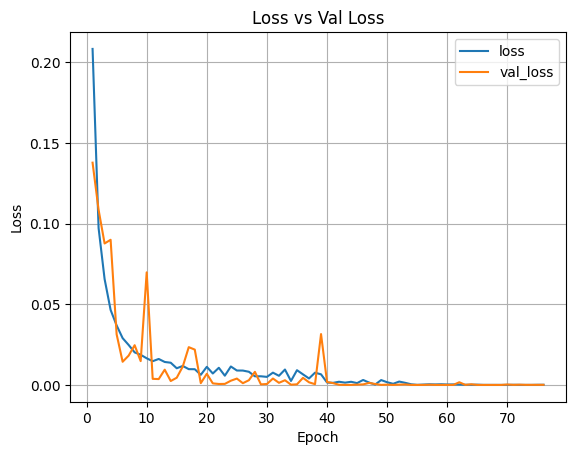

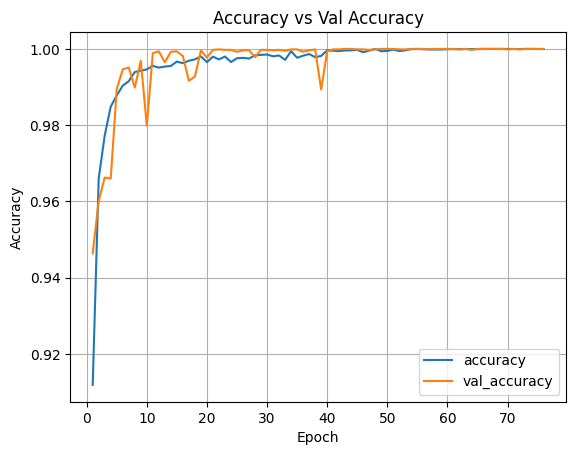

[STEP 13] Plots generated ✅


In [16]:
# ==================== Cell 12 — Train FINAL generalized TSception model ====================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import tensorflow as tf

print("[STEP 12] Preparing train/validation split (80/20) — memory safe...")

# --------------------------------------------------
# Reduce memory footprint
# --------------------------------------------------
X_bal = X_bal.astype(np.float16)

# --------------------------------------------------
# Memory-safe stratified split using INDICES
# --------------------------------------------------
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.20,
    random_state=42
)

indices = np.arange(len(y_bal))
train_idx, val_idx = next(sss.split(indices, y_bal.astype(int)))

X_train = X_bal[train_idx]
X_val   = X_bal[val_idx]
y_train = y_bal[train_idx]
y_val   = y_bal[val_idx]

print("[STEP 12] Split complete ✅")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)

# --------------------------------------------------
# FIX: Remove extra channel dimension (legacy)
# TSception-DeformerInput expects (B, C, T)
# --------------------------------------------------
if X_train.ndim == 4 and X_train.shape[-1] == 1:
    X_train = np.squeeze(X_train, axis=-1)
    X_val   = np.squeeze(X_val, axis=-1)

print("[STEP 12] After squeezing:")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)

assert X_train.ndim == 3, "Model expects input shape (B, C, T)"

# --------------------------------------------------
# Class balance check
# --------------------------------------------------
u_tr, c_tr = np.unique(y_train.astype(int), return_counts=True)
u_va, c_va = np.unique(y_val.astype(int), return_counts=True)

print("[STEP 12] Class counts (train):", dict(zip(u_tr, c_tr)))
print("[STEP 12] Class counts (val)  :", dict(zip(u_va, c_va)))

# --------------------------------------------------
# Enable GPU memory growth
# --------------------------------------------------
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# --------------------------------------------------
# Build TSception model (UNCHANGED architecture, binary output)
# --------------------------------------------------
print("[STEP 12] Building TSception model...")

model = build_tsception_keras_deformer_input(
    num_chan=X_train.shape[1],      # e.g. 127
    num_time=X_train.shape[2],      # e.g. 100
    sampling_rate=100,              # ⚠️ set correctly for your dataset
    num_T=9,
    num_S=6,
    hidden=128,
    dropout_rate=0.5,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="accuracy",
            threshold=0.5
        )
    ],
)

print("[STEP 12] Model built ✅")
model.summary()

# --------------------------------------------------
# Callbacks
# --------------------------------------------------
print("[STEP 12] Setting callbacks (monitoring val_loss)...")

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_plateau = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

csv_logger = CSVLogger("ad_final_tsception_train_log.csv", append=False)
callbacks = [early_stop, lr_plateau, csv_logger]

# --------------------------------------------------
# Training
# --------------------------------------------------
print("[STEP 12] Starting training on TRAIN set + validating on VAL set...")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=8,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

print("[STEP 12] Training complete ✅")

# --------------------------------------------------
# Save final model
# --------------------------------------------------
final_model_path = "ad_tsception-v1.keras"
model.save(final_model_path)

print("✅ Final model saved:", final_model_path)
print("✅ Training log saved: ad_final_tsception_train_log.csv")

# --------------------------------------------------
# Plot training curves
# --------------------------------------------------
print("[STEP 13] Plotting training curves...")

hist = history.history
epochs_ran = range(1, len(hist["loss"]) + 1)

# ---- Loss ----
plt.figure()
plt.plot(epochs_ran, hist["loss"], label="loss")
plt.plot(epochs_ran, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Val Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Accuracy ----
plt.figure()
plt.plot(epochs_ran, hist["accuracy"], label="accuracy")
plt.plot(epochs_ran, hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("[STEP 13] Plots generated ✅")
